In [1]:
import numpy as np
import pandas as pd
import glob
import sys
import os
import gc
import open3d as o3d

from shapely.ops import cascaded_union, polygonize
from shapely.geometry import Polygon, LineString
import shapely.geometry as geometry

from scipy import optimize
from scipy.spatial import ConvexHull, convex_hull_plot_2d, Delaunay
import scipy.io as sio

from matplotlib import pyplot as plt
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D

import math
from math import pi

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score

from descartes import PolygonPatch

In [2]:
# Read in csvs with data produced from CloudDBH file
wytham_ss_dbh_path = '/Users/snix/Documents/2021-2023/UCL/Dissertation/Results/wytham_ss_dbh.csv'
wytham_ms_dbh_path = '/Users/snix/Documents/2021-2023/UCL/Dissertation/Results/wytham_ms_dbh.csv'
trop_dbh_path = '/Users/snix/Documents/2021-2023/UCL/Dissertation/Results/trop_dbh.csv'

# Read in QSM summary files for Wytham Woods + Tropical Datasets
wytham_qsm_path = "/Users/snix/Documents/2021-2023/UCL/Dissertation/Calders Et Al/analysis_and_figures/trees_summary.csv"
trop_qsm_path = '/Users/snix/Documents/2021-2023/UCL/Dissertation/MLA01_man.csv'


In [3]:
# Clean and organize Wytham data for modelling.
wytham_qsm = pd.read_csv(wytham_qsm_path)
wytham_qsm = wytham_qsm[['TLS_ID','stemlocx_[m]', 'stemlocy_[m]', 
                         'DBH_TLS_[m]','Hgt_pts_[m]', 
                         'VerticalCrownProjectedArea_pts_[m2]', 
                         'Vol_QSM_avg_[m3]','Vol_QSM_D0_25mm_avg_[m3]', 
                         'Vol_QSM_D25_50mm_avg_[m3]', 'Vol_QSM_D50_75mm_avg_[m3]',
                         'Vol_QSM_D75_100mm_avg_[m3]', 'Vol_QSM_D100_200mm_avg_[m3]', 
                         'Vol_QSM_D200_500mm_avg_[m3]','Vol_QSM_D500_1000mm_avg_[m3]', 
                         'Vol_QSM_D1000mm_avg_[m3]']]
wytham_qsm['TLS_ID'] = wytham_qsm['TLS_ID'].astype(str)

# Make Wytham DBH dataset 
wytham_ss_dbh = pd.read_csv(wytham_ss_dbh_path, index_col = [0])
wytham_ss_dbh['TLS_ID'] = wytham_ss_dbh['TLS_ID'].astype(str)

wytham_ms_dbh = pd.read_csv(wytham_ms_dbh_path, index_col = [0])
wytham_ms_dbh['TLS_ID'] = wytham_ms_dbh['TLS_ID'].astype(str)

# Multi-stems have to be at least 10cm DBH.
wytham_ms_dbh = wytham_ms_dbh[wytham_ms_dbh['dbhadj'] > 0.1]

# Concatenate single + multi-stems to get full Wytham dataset.
wytham_dbh = pd.concat([wytham_ss_dbh, wytham_ms_dbh])

# Set aside flagged trees to see if models can estimate later.
wytham_flagged = wytham_dbh[wytham_dbh['Flagged']==1]

# Merge DBH and QSM datasets for modelling.
wytham = wytham_dbh.merge(wytham_qsm, on ='TLS_ID').dropna(axis=0)


In [4]:
# Clean and organize tropical data for modelling.
trop_qsm = pd.read_csv(trop_qsm_path)
trop_qsm['TLS_ID'] = trop_qsm['tree'].str[11:]
trop_qsm = trop_qsm.drop(['tree', 'x_m', 'y_m'], axis='columns')

# Make tropical DBH dataset
trop_dbh = pd.read_csv(trop_dbh_path, index_col = [0])
trop_dbh['TLS_ID'] = trop_dbh['TLS_ID'].astype(str)

# Set aside flagged trees to see if models can estimate later.
trop_flagged = trop_dbh[trop_dbh['Flagged']==1]

# Merge DBH and QSM for modelling.
tropical = trop_dbh.merge(trop_qsm, on ='TLS_ID').dropna(axis=0)


In [5]:
# Set font for plotting.
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

Text(0, 0.5, 'DBH from TLS')

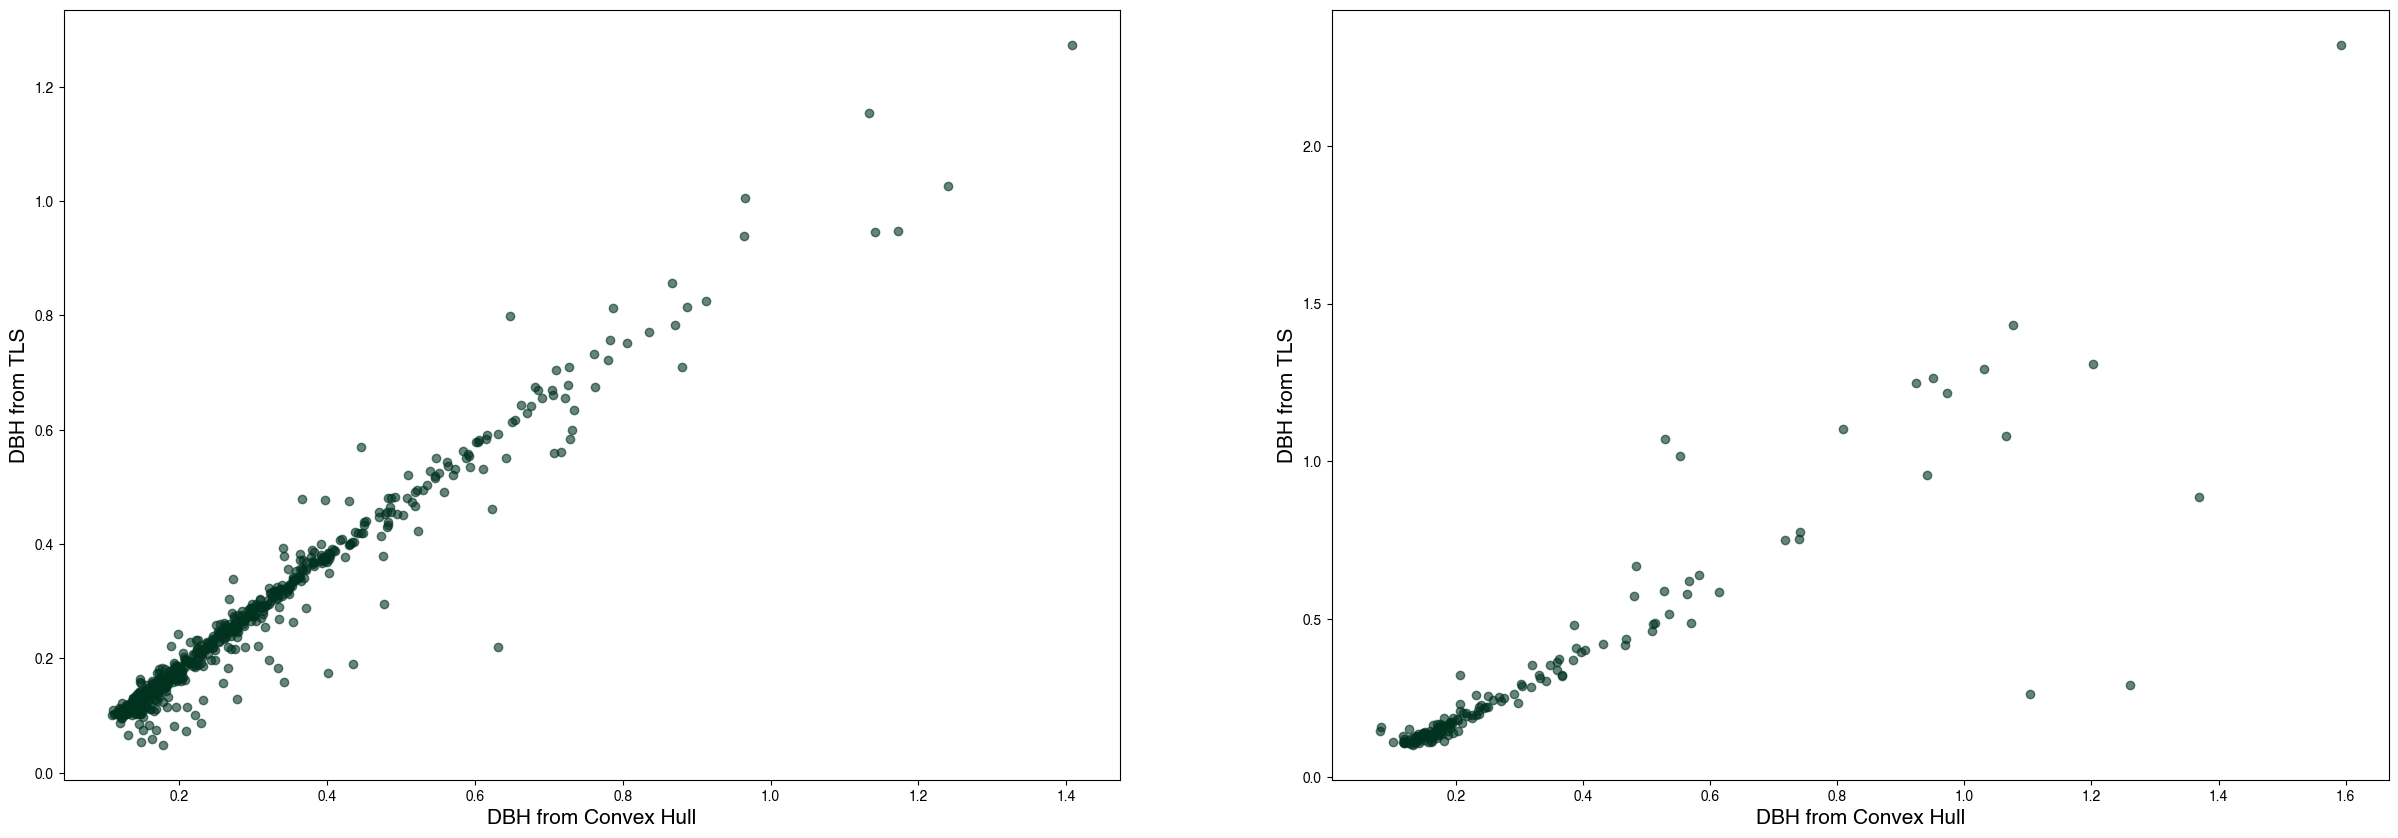

In [6]:
# Plot TLS DBH vs. 'field DBH' calculated from convex hull 
fig, axs = plt.subplots(1, 2, figsize=(30,10))

# Wytham Woods:
axs[0].scatter(wytham['dbhadj'], wytham['DBH_TLS_[m]'], color='#013220', alpha=0.6)
axs[0].set_xlabel('DBH from Convex Hull', fontsize=15)
axs[0].set_ylabel('DBH from TLS', fontsize=15)

# Tropical:
axs[1].scatter(tropical['dbhadj'], tropical['DBHqsm'], color='#013220', alpha=0.6)
axs[1].set_xlabel('DBH from Convex Hull', fontsize=15)
axs[1].set_ylabel('DBH from TLS', fontsize=15)


In [7]:
# Drop flagged trees from dataset before modelling
print(f'length of wytham before {len(wytham)}')
wytham  = wytham[wytham['Flagged']==0]
print(f'length of wytham after {len(wytham)}')

print(f'length of tropical before {len(tropical)}')
tropical  = tropical[tropical['Flagged']==0]
print(f'length of tropical after {len(tropical)}')

length of wytham before 597
length of wytham after 584
length of tropical before 163
length of tropical after 157


In [8]:
def set_up_RF(treedata, dataname):
    """ 
    Set up labels and features for RF modelling.
    
    Args:
    treedata - 
    dataname - Either 'Wytham' or 'Tropical', which determines which columns to remove
    
    Returns:
    labels - array of values to predict
    features - array of values used to predict the labels 
    featurelist - list of all the feature names
    """
    
    # Set labels (values we want models to predict)
    labels = np.array(treedata['dbhadj'])
    
    # Depending on dataset, remove labels (and other DBH columns) from features.
    if dataname == 'wytham':
        features = treedata.drop(['TLS_ID','dbhadj', 'dbh13', 'DBH_TLS_[m]', 'dbhcirc'], axis = 1)
    if dataname == 'tropical':
        features = treedata.drop(['TLS_ID','dbhadj', 'dbh13', 'DBHqsm', 'DBHcyl', 'dbhcirc'], axis = 1)
    
    # Save feature names in a list for later
    featurelist = list(features.columns)
    
    # Convert features to numpy array.
    features = np.array(features)
    
    return labels, features, featurelist

In [9]:
# Set up hyperparameter grids to tune within. 

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = [1, 2, 4, 6, 8, 10, 12, 14, 16]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [10]:
def run_models(features, labels, random_grid, verbose=False):
    """
    Train and run random forest models.
    
    Splits the dataset into training/testing, initializes the models,
    tunes the hyperparameter grid and then evaluates the performance of the 
    model using the hyperparameter grid against a base RF model. 
    
    Code in this function is based on 
    https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    
    Args: 
    features - array of the values used to predict the labels
    labels - array of the values the model aims to predict
    random_grid - grid of the hyperparameter ranges to be tuned within
    verbose - optional, prints out additional details about the models if True
    
    Returns:
    best_random - best model resulting from tuning the hyperparameter grid 
    random_predictions - predicted DBH values from the best_random model 
    random_errors - the errors associated with best_random model 
    test_labels - the labels used for testing (needed for plotting later)
    """
    # Split training and testing.
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, train_size = 0.60, random_state = 42)
    
    if verbose:
        print('Training Features Shape:', train_features.shape)
        print('Training Labels Shape:', train_labels.shape)
        print('Testing Features Shape:', test_features.shape)
        print('Testing Labels Shape:', test_labels.shape)
    
    
    # Get best model with hyperparameter tuning
    rf = RandomForestRegressor()
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 300, cv = 4, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(train_features, train_labels)
    best_random = rf_random.best_estimator_
    
    
    # Get best model without hyperparameter tuning
    rf_base = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    rf_base.fit(train_features, train_labels)
    
    def evaluate(model, test_features, test_labels, verbose=verbose):
        predictions = model.predict(test_features)
        errors = abs(predictions - test_labels)
        mape = 100 * np.mean(errors / test_labels)
        accuracy = 100 - mape
        if verbose: 
            print('Model Performance')
            print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
            print('Accuracy = {:0.2f}%.'.format(accuracy))

        return accuracy, predictions, errors
    
    # Evaluate model performance
    random_accuracy, random_predictions, random_errors = evaluate(best_random, test_features, test_labels)
    base_accuracy, base_predictions, base_errors = evaluate(rf_base, test_features, test_labels)

    if verbose: print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))    
    
    return best_random, random_predictions, random_errors, test_labels



In [11]:
def var_importance(model, featurelist, print_results=False):
    """
    Get and return variable importance metrics from RF model.
    
    Args:
    model - model for which variable importance will be returned
    featurelist - the list of feature names (column names) of predictors
    print_results - optional value, if True, prints the list of var importance
    
    Returns:
    feature_importance - list of the variable importances for the given model
    """
    # Get numerical feature importances
    importances = list(model.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(featurelist, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    if print_results: [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
    return feature_importances
    

# Run Models

In [12]:
w_labels, w_features, w_featurelist = set_up_RF(wytham, 'wytham')
w_best_random, w_predictions, w_errors, w_test_labels = run_models(w_features, w_labels, random_grid, verbose=False)
w_feature_importances = var_importance(w_best_random, w_featurelist, print_results=False) 

t_labels, t_features, t_featurelist = set_up_RF(tropical, 'tropical')
t_best_random, t_predictions, t_errors, t_test_labels = run_models(t_features, t_labels, random_grid, verbose=False)
t_feature_importances = var_importance(t_best_random, t_featurelist, print_results=False)

Fitting 4 folds for each of 300 candidates, totalling 1200 fits
Fitting 4 folds for each of 300 candidates, totalling 1200 fits
[CV] END bootstrap=False, max_depth=70, max_features=16, min_samples_leaf=4, min_samples_split=7, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=8, min_samples_leaf=5, min_samples_split=7, n_estimators=1200; total time=   1.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=4, n_estimators=1000; total time=   0.7s
[CV] END bootstrap=True, max_depth=110, max_features=16, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, max_features=14, min_samples_leaf=5, min_samples_split=7, n_estimators=800; total time=   1.0s
[CV] END bootstrap=False, max_depth=50, max_features=1, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=12, min_sam

[CV] END bootstrap=False, max_depth=70, max_features=16, min_samples_leaf=4, min_samples_split=7, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=8, min_samples_leaf=5, min_samples_split=7, n_estimators=1200; total time=   1.0s
[CV] END bootstrap=False, max_depth=90, max_features=6, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   1.3s
[CV] END bootstrap=True, max_depth=40, max_features=16, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   0.9s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=2, min_samples_split=7, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=4, min_samples_split=6, n_estimators=2000; total time=   1.3s
[CV] END bootstrap=False, max_depth=50, max_features=1, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   0.7s
[CV] END bootstrap=False, max_depth=20, max_features=4, min

[CV] END bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=7, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, max_features=8, min_samples_leaf=5, min_samples_split=9, n_estimators=1400; total time=   1.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=4, n_estimators=1000; total time=   0.7s
[CV] END bootstrap=True, max_depth=110, max_features=16, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, max_features=14, min_samples_leaf=5, min_samples_split=7, n_estimators=800; total time=   1.0s
[CV] END bootstrap=False, max_depth=50, max_features=10, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   0.4s
[CV] END bootstrap=False, max_depth=40, max_features=8, min_samples_leaf=5, min_samples_split=6, n_estimators=1200; total time=   1.1s
[CV] END bootstrap=False, max_depth=50, max_features=14,

[CV] END bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=7, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, max_features=8, min_samples_leaf=5, min_samples_split=9, n_estimators=1400; total time=   1.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=4, n_estimators=1000; total time=   0.7s
[CV] END bootstrap=True, max_depth=110, max_features=16, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, max_features=14, min_samples_leaf=5, min_samples_split=7, n_estimators=800; total time=   1.0s
[CV] END bootstrap=False, max_depth=50, max_features=1, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=12, min_samples_leaf=4, min_samples_split=8, n_estimators=1200; total time=   1.4s
[CV] END bootstrap=False, max_depth=50, max_features=14, 

[CV] END bootstrap=True, max_depth=40, max_features=16, min_samples_leaf=1, min_samples_split=6, n_estimators=1200; total time=   1.5s
[CV] END bootstrap=False, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=3, n_estimators=1800; total time=   2.0s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=2, min_samples_split=7, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=4, min_samples_split=6, n_estimators=2000; total time=   1.3s
[CV] END bootstrap=False, max_depth=50, max_features=1, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   0.6s
[CV] END bootstrap=False, max_depth=20, max_features=4, min_samples_leaf=2, min_samples_split=8, n_estimators=1600; total time=   1.1s
[CV] END bootstrap=True, max_depth=80, max_features=1, min_samples_leaf=4, min_samples_split=9, n_estimators=800; total time=   0.5s
[CV] END bootstrap=False, max_depth=110, max_features=16,

[CV] END bootstrap=False, max_depth=70, max_features=16, min_samples_leaf=4, min_samples_split=7, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=8, min_samples_leaf=5, min_samples_split=7, n_estimators=1200; total time=   1.0s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=4, n_estimators=1000; total time=   0.7s
[CV] END bootstrap=True, max_depth=110, max_features=16, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, max_features=14, min_samples_leaf=5, min_samples_split=7, n_estimators=800; total time=   1.0s
[CV] END bootstrap=False, max_depth=50, max_features=10, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   0.4s
[CV] END bootstrap=False, max_depth=40, max_features=8, min_samples_leaf=5, min_samples_split=6, n_estimators=1200; total time=   1.1s
[CV] END bootstrap=True, max_depth=20, max_features=4, 

[CV] END bootstrap=False, max_depth=70, max_features=16, min_samples_leaf=4, min_samples_split=7, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=8, min_samples_leaf=5, min_samples_split=7, n_estimators=1200; total time=   1.1s
[CV] END bootstrap=False, max_depth=90, max_features=6, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   1.3s
[CV] END bootstrap=True, max_depth=40, max_features=16, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=4, min_samples_split=6, n_estimators=2000; total time=   1.2s
[CV] END bootstrap=False, max_depth=50, max_features=1, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   0.7s
[CV] END bootstrap=False, max_depth=20, max_features=4, min_samples_leaf=2, min_samples_split=8, n_estimators=1600; total time=   1.2s
[CV] END bootstrap=True, max_depth=80, max_features=1, min

[CV] END bootstrap=True, max_depth=40, max_features=16, min_samples_leaf=1, min_samples_split=6, n_estimators=1200; total time=   1.5s
[CV] END bootstrap=False, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=3, n_estimators=1800; total time=   2.0s
[CV] END bootstrap=False, max_depth=50, max_features=10, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   0.4s
[CV] END bootstrap=False, max_depth=40, max_features=8, min_samples_leaf=5, min_samples_split=6, n_estimators=1200; total time=   1.1s
[CV] END bootstrap=True, max_depth=20, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=400; total time=   0.3s
[CV] END bootstrap=False, max_depth=90, max_features=8, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   1.0s
[CV] END bootstrap=False, max_depth=100, max_features=1, min_samples_leaf=3, min_samples_split=9, n_estimators=1200; total time=   0.6s
[CV] END bootstrap=False, max_depth=60, max_features=

[CV] END bootstrap=True, max_depth=40, max_features=16, min_samples_leaf=1, min_samples_split=6, n_estimators=1200; total time=   1.5s
[CV] END bootstrap=False, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=3, n_estimators=1800; total time=   2.0s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=2, min_samples_split=7, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=50, max_features=1, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=12, min_samples_leaf=4, min_samples_split=8, n_estimators=1200; total time=   1.3s
[CV] END bootstrap=False, max_depth=50, max_features=14, min_samples_leaf=1, min_samples_split=3, n_estimators=2000; total time=   3.1s
[CV] END bootstrap=False, max_depth=90, max_features=14, min_samples_leaf=4, min_samples_split=7, n_estimators=1800; total time=   2.4s
[CV] END bootstrap=False, max_depth=90, max_features

# Plot Results

## Predicted vs. Measured DBH

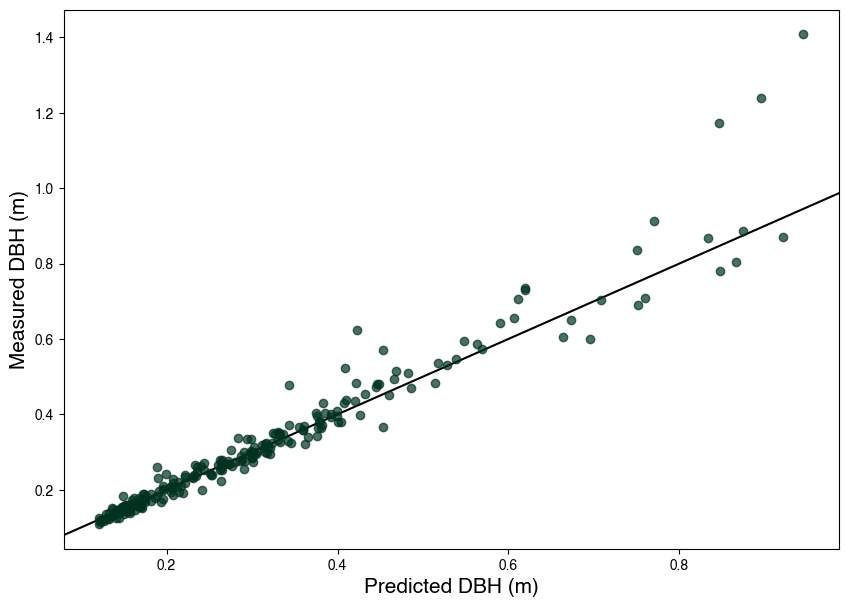

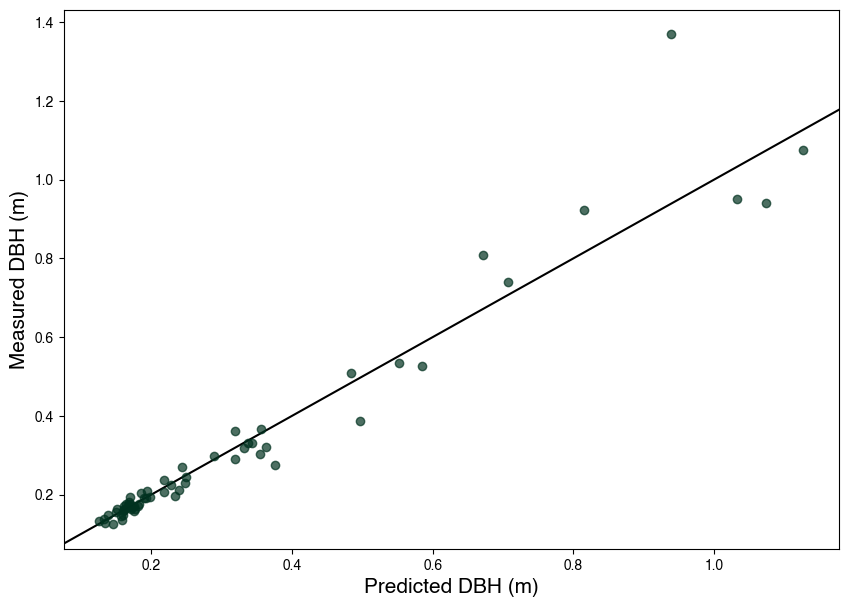

In [13]:
wytham_rf_results = pd.DataFrame({'errors': w_errors, 'predictions': w_predictions, 'test_labels': w_test_labels}, columns=['mape', 'errors', 'predictions', 'test_labels'])
trop_rf_results = pd.DataFrame({'errors': t_errors, 'predictions': t_predictions, 'test_labels': t_test_labels}, columns=['mape', 'errors', 'predictions', 'test_labels'])

for result_df in [wytham_rf_results, trop_rf_results]:
    plt.figure(figsize=(10,7))
    plt.axline((0.2, 0.2), slope=1, color = 'black', zorder = 1)
    plt.scatter(result_df['predictions'], result_df['test_labels'], color='#013220', alpha=0.7, zorder=2)
    plt.xlabel('Predicted DBH (m)', fontsize=15)
    plt.ylabel('Measured DBH (m)', fontsize=15)
    plt.annotate("r-squared = {:.3f}".format(r2_score(w_predictions, w_test_labels)), (0, 1))

## Errors by Size of Tree 

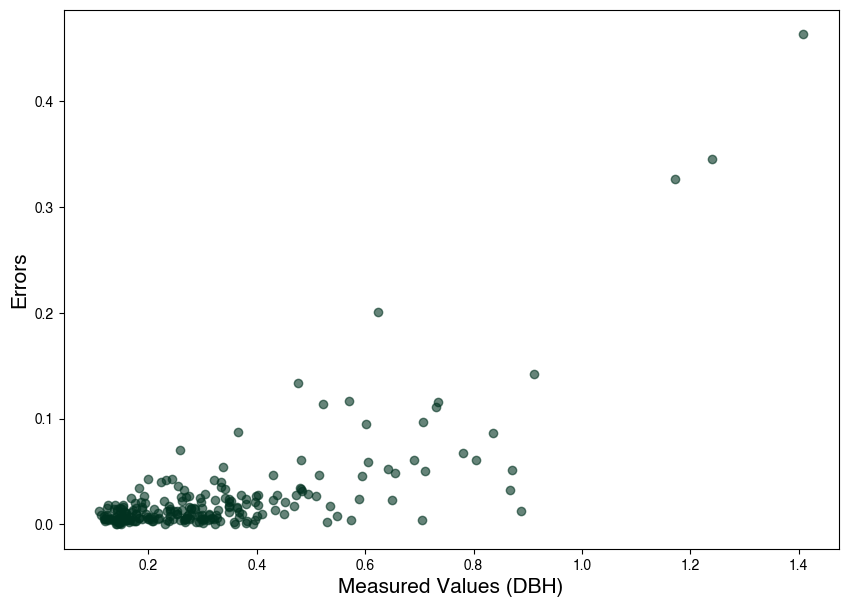

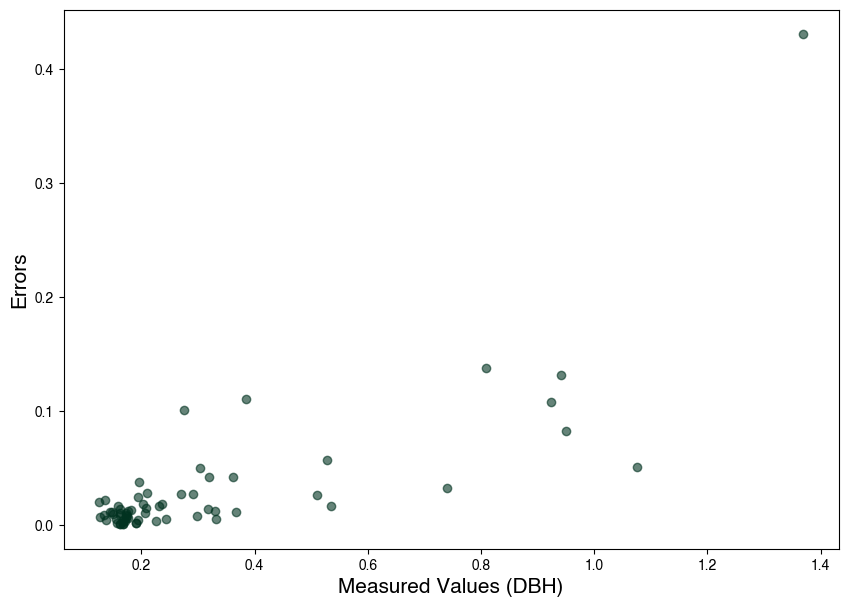

In [14]:
for result_df in [wytham_rf_results, trop_rf_results]:
    plt.figure(figsize=(10,7))
    plt.scatter(result_df['test_labels'], result_df['errors'], color='#013220', alpha=0.6)
    plt.xlabel('Measured Values (DBH)', fontsize=15)
    plt.ylabel('Errors', fontsize=15)

## Errors (Normalized) by Size of Tree

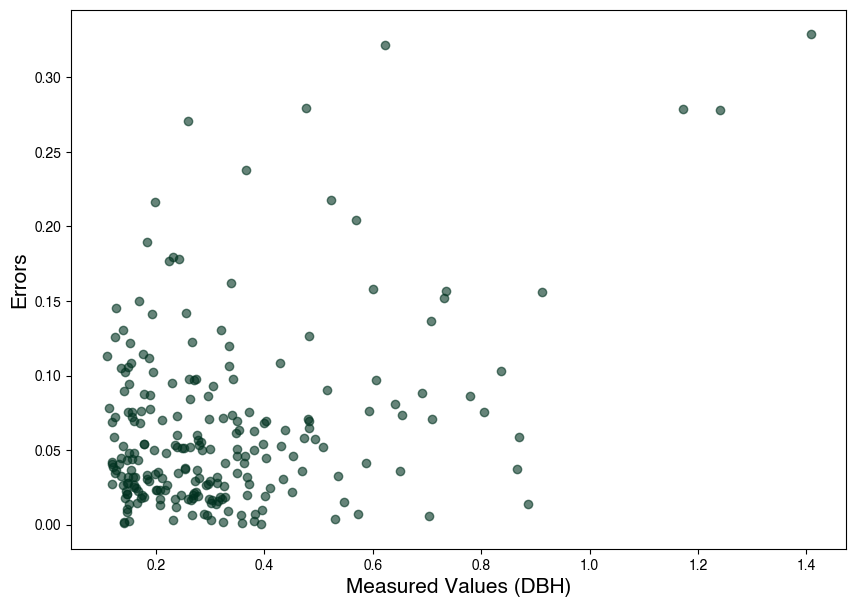

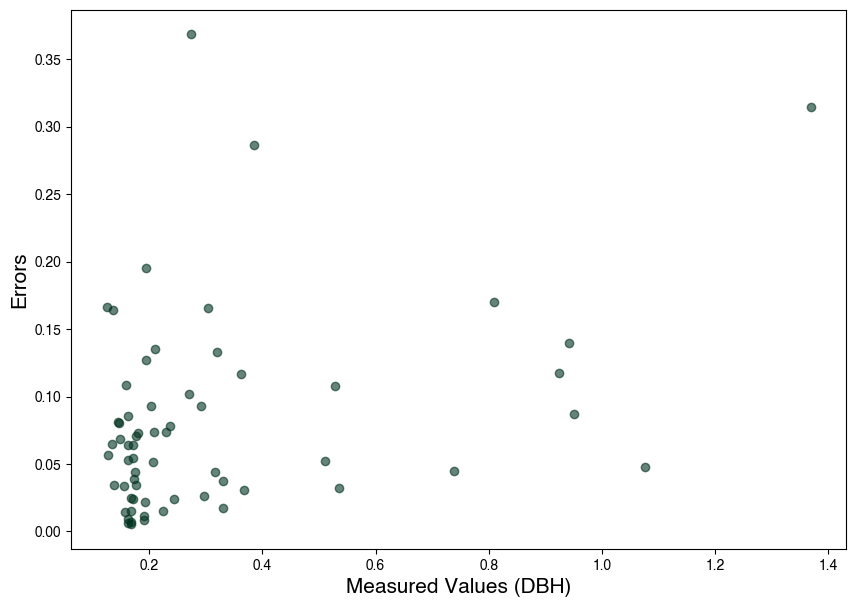

[CV] END bootstrap=True, max_depth=None, max_features=4, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   1.0s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=2, min_samples_split=9, n_estimators=1200; total time=   0.7s
[CV] END bootstrap=False, max_depth=None, max_features=6, min_samples_leaf=2, min_samples_split=9, n_estimators=800; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, max_features=16, min_samples_leaf=4, min_samples_split=9, n_estimators=1600; total time=   1.0s
[CV] END bootstrap=False, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=7, n_estimators=2000; total time=   0.9s
[CV] END bootstrap=False, max_depth=90, max_features=6, min_samples_leaf=5, min_samples_split=10, n_estimators=1800; total time=   1.0s
[CV] END bootstrap=True, max_depth=40, max_features=1, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_feature

[CV] END bootstrap=False, max_depth=60, max_features=14, min_samples_leaf=5, min_samples_split=6, n_estimators=2000; total time=   1.1s
[CV] END bootstrap=False, max_depth=110, max_features=12, min_samples_leaf=4, min_samples_split=4, n_estimators=800; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, max_features=14, min_samples_leaf=4, min_samples_split=3, n_estimators=1000; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_features=4, min_samples_leaf=2, min_samples_split=4, n_estimators=1400; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, max_features=12, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=   0.2s
[CV] END bootstrap=True, max_depth=60, max_features=12, min_samples_leaf=4, min_samples_split=4, n_estimators=1600; total time=   1.1s
[CV] END bootstrap=False, max_depth=100, max_features=6, min_samples_leaf=5, min_samples_split=6, n_estimators=1600; total time=   0.9s
[CV] END bootstrap=False, max_depth=100, max_features

[CV] END bootstrap=True, max_depth=10, max_features=16, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=4, n_estimators=1400; total time=   0.9s
[CV] END bootstrap=False, max_depth=100, max_features=10, min_samples_leaf=1, min_samples_split=3, n_estimators=800; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=600; total time=   0.4s
[CV] END bootstrap=True, max_depth=110, max_features=10, min_samples_leaf=3, min_samples_split=9, n_estimators=400; total time=   0.3s
[CV] END bootstrap=True, max_depth=60, max_features=16, min_samples_leaf=1, min_samples_split=6, n_estimators=1600; total time=   1.2s
[CV] END bootstrap=True, max_depth=50, max_features=4, min_samples_leaf=1, min_samples_split=7, n_estimators=2000; total time=   1.2s
[CV] END bootstrap=False, max_depth=50, max_features=10, m

In [15]:
for result_df in [wytham_rf_results, trop_rf_results]:
    plt.figure(figsize=(10,7))
    plt.scatter(result_df['test_labels'], result_df['errors'] / result_df['test_labels'], color='#013220', alpha=0.6)
    plt.xlabel('Measured Values (DBH)', fontsize=15)
    plt.ylabel('Errors', fontsize=15)

# Allometry

Text(0, 0.5, 'Measured DBH (m)')

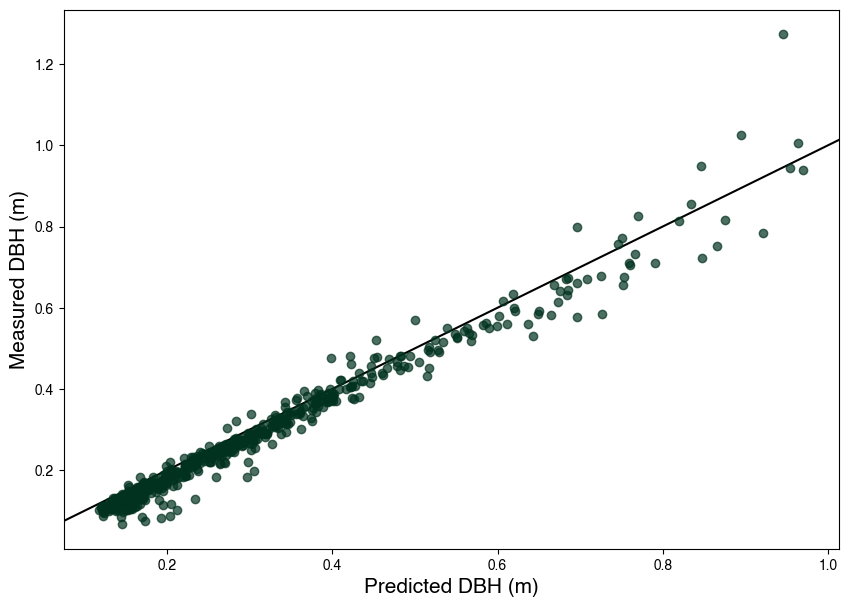

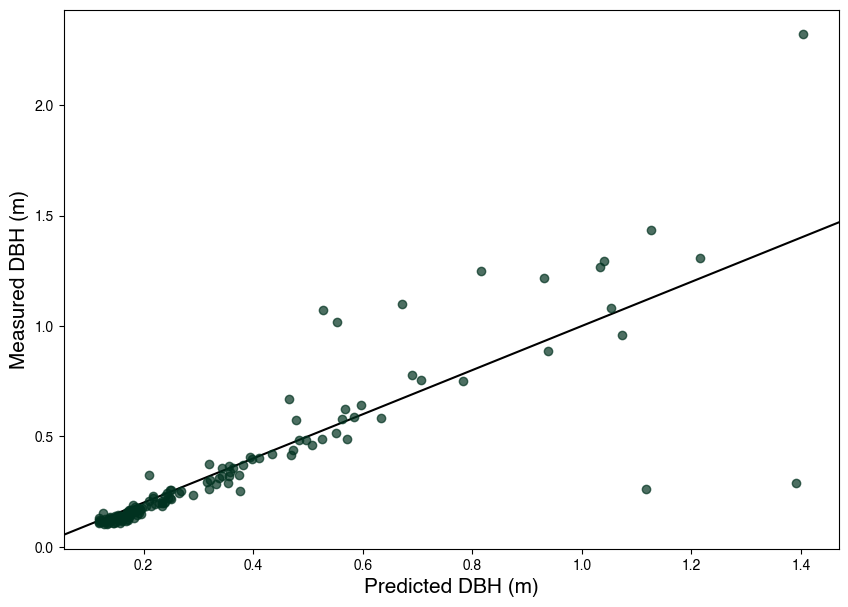

In [16]:
# Make array of all Wytham trees.
all_wytham_features = wytham.drop(['TLS_ID','dbhadj', 'dbh13', 'DBH_TLS_[m]', 'dbhcirc'], axis = 1)
all_wytham_featurelist = list(all_wytham_features.columns)
all_wytham_features = np.array(all_wytham_features)

# Make array of all tropical trees.
all_tropical_features = tropical.drop(['TLS_ID','dbhadj', 'dbh13', 'DBHqsm', 'DBHcyl', 'dbhcirc'], axis = 1)
all_tropical_featurelist = list(all_tropical_features.columns)
all_tropical_features = np.array(all_tropical_features)

# Predict entire dataset using best model from above.
all_wytham_predictions = w_best_random.predict(all_wytham_features)
all_tropical_predictions = t_best_random.predict(all_tropical_features)

# Add predictions back into each forest dataset.
wytham['predicteddbh'] = all_wytham_predictions
tropical['predicteddbh'] = all_tropical_predictions

# Plot results
plt.figure(figsize=(10,7))
plt.axline((0.2, 0.2), slope=1, color = 'black', zorder = 1)
plt.scatter(wytham['predicteddbh'], wytham['DBH_TLS_[m]'], color='#013220', alpha=0.7, zorder=2)
plt.xlabel('Predicted DBH (m)', fontsize=15)
plt.ylabel('Measured DBH (m)', fontsize=15)

plt.figure(figsize=(10,7))
plt.axline((0.2, 0.2), slope=1, color = 'black', zorder = 1)
plt.scatter(tropical['predicteddbh'], tropical['DBHqsm'], color='#013220', alpha=0.7, zorder=2)
plt.xlabel('Predicted DBH (m)', fontsize=15)
plt.ylabel('Measured DBH (m)', fontsize=15)


In [17]:
# Run to get allometry function
%run '/Users/snix/Documents/2021-2023/UCL/Dissertation/CloudDBH/CloudDBH_Functions.ipynb'

In [18]:
wytham_results = wytham_allometry(wytham, 'allometry_hull', 'dbhadj')
wytham_results = wytham_allometry(wytham, 'allometry_circle', 'dbhcirc')
wytham_results = wytham_allometry(wytham, 'allometry_pred', 'predicteddbh')

# Convex Hull vs. TLS:
errors = abs(wytham_results['allometry_hull'] - wytham_results['Vol_QSM_avg_[m3]'])
mape = 100 * np.mean(errors / wytham_results['Vol_QSM_avg_[m3]'])
print(f'agreement - hull vs. tls: {100 - mape}')

# Circle vs. TLS:
errors = abs(wytham_results['allometry_circle'] - wytham_results['Vol_QSM_avg_[m3]'])
mape = 100 * np.mean(errors / wytham_results['Vol_QSM_avg_[m3]'])
print(f'agreement - circle vs. tls: {100 - mape}')

# Predicted Convex Hull vs. TLS:
errors = abs(wytham_results['allometry_pred'] - wytham_results['Vol_QSM_avg_[m3]'])
mape = 100 * np.mean(errors / wytham_results['Vol_QSM_avg_[m3]'])
print(f'agreement - predicted vs. tls: {100 - mape}')

# Sum total volumes
hull_volume = np.sum(wytham_results[['allometry_hull']])
circ_volume = np.sum(wytham_results[['allometry_circle']])
pred_volume = np.sum(wytham_results[['allometry_pred']])
tls_volume = np.sum(wytham_results[['Vol_QSM_avg_[m3]']])

print(f'hull: {hull_volume}, circle: {circ_volume}, predicted: {pred_volume}, tls: {tls_volume}')

agreement - hull vs. tls: 57.45282384783929
agreement - circle vs. tls: 76.49463412751034
agreement - predicted vs. tls: 62.972696398634284
hull: allometry_hull    1179.166149
dtype: float64, circle: allometry_circle    949.436506
dtype: float64, predicted: allometry_pred    1086.107113
dtype: float64, tls: Vol_QSM_avg_[m3]    1014.11028
dtype: float64


In [19]:
tropical_results = trop_allometry(tropical, 'allometry_hull', 'dbhadj')
tropical_results = trop_allometry(tropical, 'allometry_circle', 'dbhcirc')
tropical_results = trop_allometry(tropical, 'allometry_pred', 'predicteddbh')

# Convex Hull vs. TLS:
errors = abs(tropical_results['allometry_hull'] - tropical_results['TotalVolume_T'])
mape = 100 * np.mean(errors / tropical_results['TotalVolume_T'])
print(f'agreement - hull vs. tls: {100-mape}')

# Circle vs. TLS:
errors = abs(tropical_results['allometry_circle'] - tropical_results['TotalVolume_T'])
mape = 100 * np.mean(errors / tropical_results['TotalVolume_T'])
print(f'agreement - circle vs. tls: {100-mape}')

# Predicted Convex Hull vs. TLS:
errors = abs(tropical_results['allometry_pred'] - tropical_results['TotalVolume_T'])
mape = 100 * np.mean(errors / tropical_results['TotalVolume_T'])
print(f'agreement - predicted vs. tls: {100-mape}')

# Sum total volumes
hull_volume = np.sum(tropical_results[['allometry_hull']])
circ_volume = np.sum(tropical_results[['allometry_circle']])
pred_volume = np.sum(tropical_results[['allometry_pred']])
tls_volume = np.sum(tropical_results[['TotalVolume_T']])

print(f'hull: {hull_volume}, circle: {circ_volume}, predicted: {pred_volume}, tls: {tls_volume}')

agreement - hull vs. tls: 59.915636283823055
agreement - circle vs. tls: 60.64799619381404
agreement - predicted vs. tls: 62.54405933875195
hull: allometry_hull    571.1825
dtype: float64, circle: allometry_circle    505.972161
dtype: float64, predicted: allometry_pred    549.753739
dtype: float64, tls: TotalVolume_T    548.12997
dtype: float64


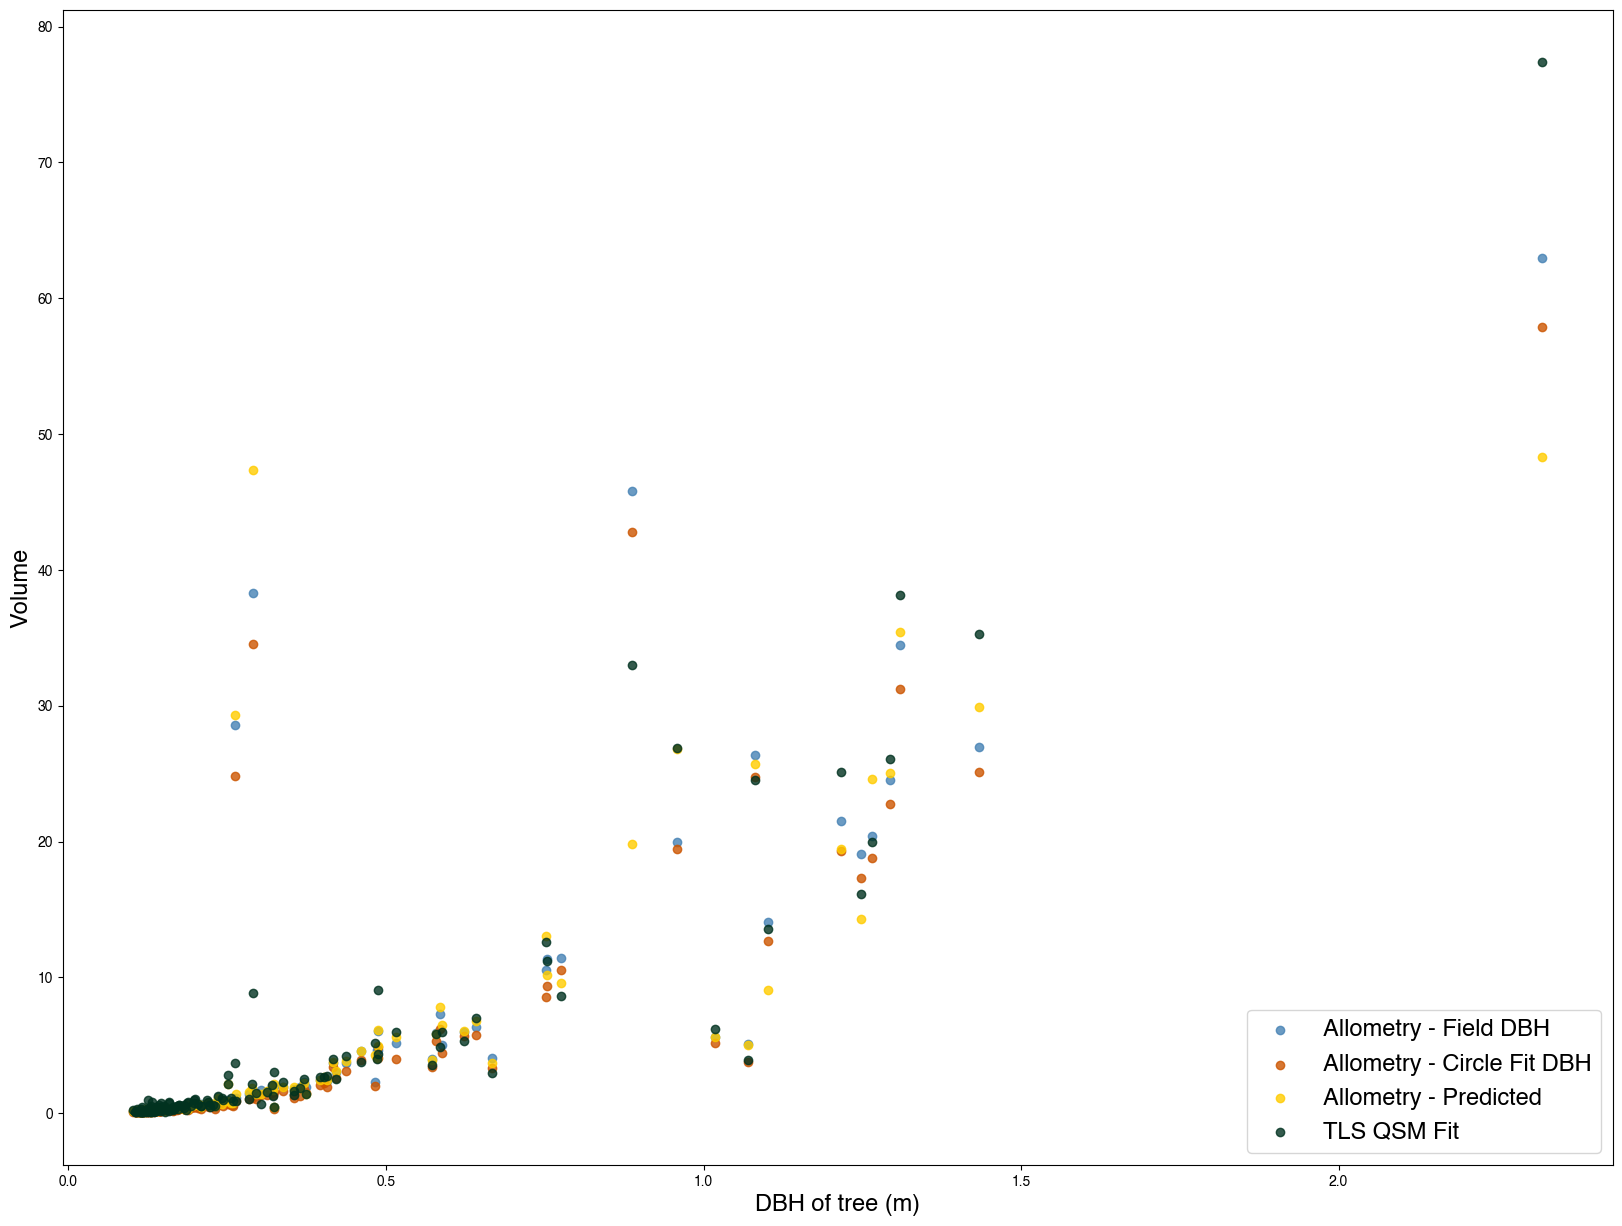

In [20]:
plt.figure(figsize=(20,15))

plt.scatter(tropical_results['DBHqsm'], tropical_results['allometry_hull'], label = 'Allometry - Field DBH', color='#4682B4', alpha=0.8)
plt.scatter(tropical_results['DBHqsm'], tropical_results['allometry_circle'], label = 'Allometry - Circle Fit DBH', color='#CC5500', alpha=0.8)
plt.scatter(tropical_results['DBHqsm'], tropical_results['allometry_pred'], label = 'Allometry - Predicted', color='#FFCC00', alpha=0.8)
plt.scatter(tropical_results['DBHqsm'], tropical_results['TotalVolume_T'], label = 'TLS QSM Fit', color='#013220', alpha=0.8)
plt.xlabel('DBH of tree (m)', fontsize=17)
plt.ylabel('Volume', fontsize=17)

plt.legend(loc="lower right", fontsize=17)

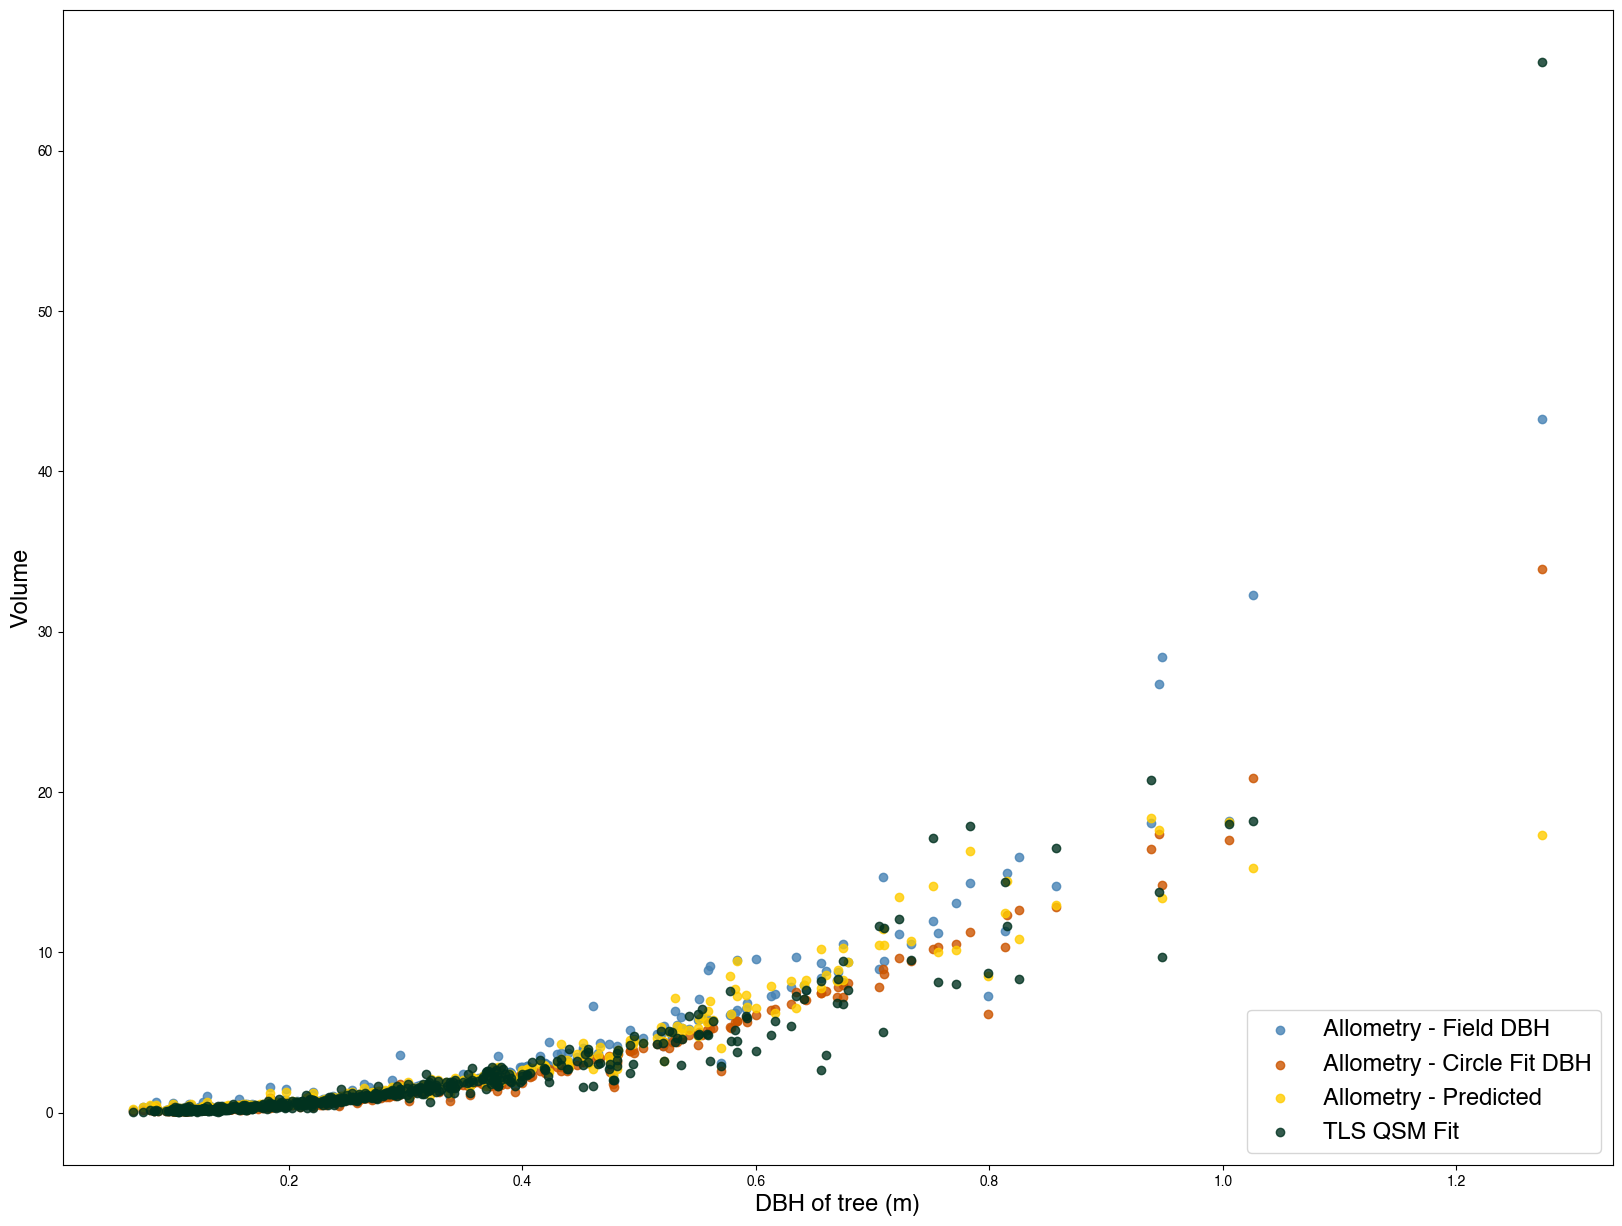

In [21]:
plt.figure(figsize=(20,15))


plt.scatter(wytham_results['DBH_TLS_[m]'], wytham_results['allometry_hull'], label = 'Allometry - Field DBH', color='#4682B4', alpha=0.8)
plt.scatter(wytham_results['DBH_TLS_[m]'], wytham_results['allometry_circle'], label = 'Allometry - Circle Fit DBH', color='#CC5500', alpha=0.8)
plt.scatter(wytham_results['DBH_TLS_[m]'], wytham_results['allometry_pred'], label = 'Allometry - Predicted', color='#FFCC00', alpha=0.8)
plt.scatter(wytham_results['DBH_TLS_[m]'], wytham_results['Vol_QSM_avg_[m3]'], label = 'TLS QSM Fit', color='#013220', alpha=0.8)
plt.xlabel('DBH of tree (m)', fontsize=17)
plt.ylabel('Volume', fontsize=17)

plt.legend(loc="lower right", fontsize=17)

Text(0, 0.5, 'DBH - Convex Hull (m)')

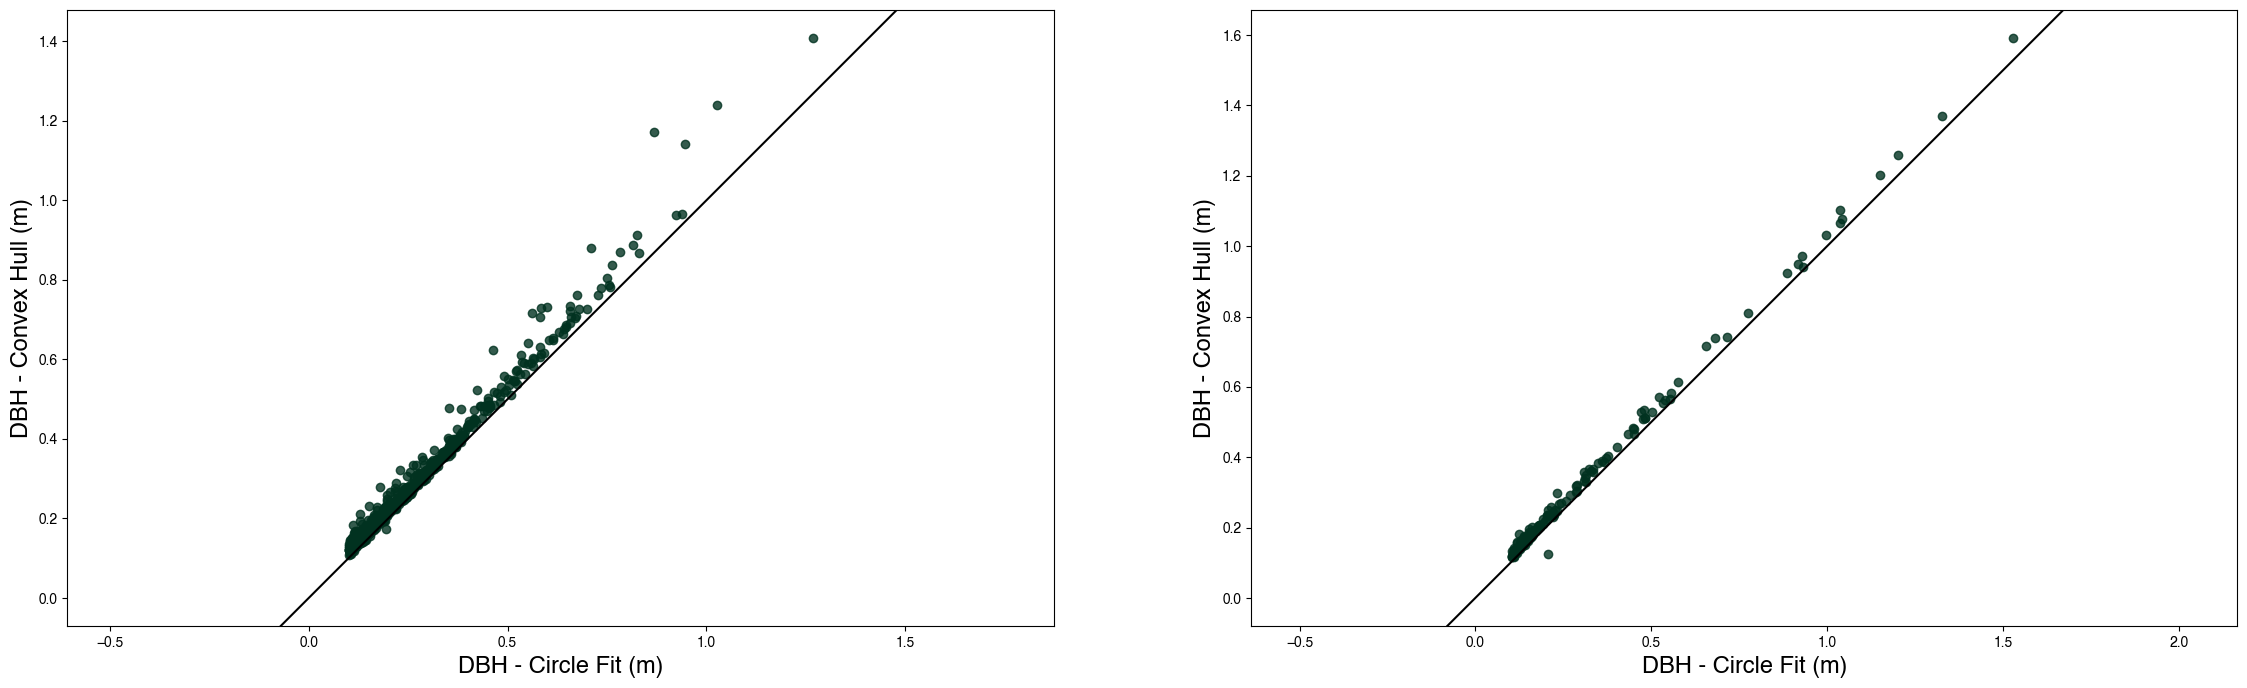

In [22]:
fig, axs = plt.subplots(1, 2, figsize = (28, 8))

axs[0].scatter(wytham['dbhcirc'], wytham['dbhadj'], color='#013220', alpha=0.8)
axs[0].axline((0, 0), slope=1, color = 'black')
axs[0].axis('equal')

axs[0].set_xlabel('DBH - Circle Fit (m)', fontsize=17)
axs[0].set_ylabel('DBH - Convex Hull (m)', fontsize=17)


axs[1].scatter(tropical['dbhcirc'], tropical['dbhadj'], color='#013220', alpha=0.8)
axs[1].axline((0, 0), slope=1, color = 'black')
axs[1].axis('equal')

axs[1].set_xlabel('DBH - Circle Fit (m)', fontsize=17)
axs[1].set_ylabel('DBH - Convex Hull (m)', fontsize=17)
